In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan

from CASutils import averaging_utils as avg

In [3]:
plotpath='/project/cas/islas/python_plots/singleforcing_paper/figures/'

### GHG

In [4]:
ghgs = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/FORCINGS/GHGs.nc")

### Solar

In [5]:
# TSI is typically around 1361, but area of a circle that this is hitting is pi x r**2, area of the sphere of the earth is 4 x pi x r**2
# so the average incoming solar radiation per m**2 of Earth should be 1/4 of this ~ 340W/m**2.  See also Trenberth et al 2009 
# (Earth's Global Energy Budget)
solin = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/FORCINGS/SOLIN.nc")
solin = solin.SOLIN.mean('M')
solin_gm = avg.cosweightlonlat(solin, 0, 360, -90, 90)

### Volcanoes and Ozone

In [6]:
### There's the continuously outgassing volcanoes.  but then there's stratospheric aerosol prescribed.
volc = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/EMISSIONS/CESM2/STRATAERO/"+
                       "ozone_strataero_WACCM_L70_zm5day_18500101-21010201_CMIP6histEnsAvg_SSP370_c190403.nc")

In [7]:
volcaod = avg.cosweightlat(volc.AODVISstdn, -90, 90)

In [8]:
volcaod = volcaod.groupby('time.year').mean('time')

In [9]:
O3 = volc.O3
O3 = O3.groupby('time.year').mean('time')

In [10]:
O3_70 = O3.interp(lev=70.)

In [11]:
O3shpol = avg.cosweightlat(O3_70,-90,-60)

### Anthropogenic aerosols

In [12]:
aer2 = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/FORCINGS/AAER.nc")
aer2_bc = aer2.anthro_bc
aer2_so2 = aer2.ene_ind_so2 + aer2.ag_so2 + aer2.restran_so2 + aer2.ship_so2
aer2_so4 = aer2.ene_ind_so4 + aer2.ag_so4 + aer2.restran_so4 + aer2.ship_so4
pom = aer2.pom
soag = aer2.soag

### Biomass burning aerosols

In [13]:
bmb2 = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/FORCINGS/BMB.nc")
bmb_bc = bmb2.bmb_bc
bmb_dms = bmb2.bmb_dms
bmb_pom = bmb2.bmb_pom
bmb_so2 = bmb2.bmb_so2
bmb_so4 = bmb2.bmb_so4
bmb_soag = bmb2.bmb_soag

### Land use

In [14]:
landusehist = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/EMISSIONS/CESM2/FLANDUSE/"+\
                          "landuse.timeseries_0.9x1.25_hist_78pfts_CMIP6_simyr1850-2015_c170824.nc")[['PCT_CROP','PCT_NAT_PFT','PCT_CFT','AREA']]
landusehist = landusehist.sel(time=slice(1850,2014))
landusessp = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/EMISSIONS/CESM2/FLANDUSE/"+\
                             "landuse.timeseries_0.9x1.25_SSP3-7.0_78pfts_CMIP6_simyr1850-2100_c190214.nc")[['PCT_CROP','PCT_NAT_PFT','PCT_CFT','AREA']]
landusessp = landusessp.sel(time=slice(2015,2099))

In [15]:
landuse = xr.concat([landusehist,landusessp], dim='time')

In [16]:
pftnames = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/EMISSIONS/CESM2/FLANDUSE/"+\
                           "clm5_params.c171117.nc")
pftnames = pftnames.pftname
pftnames_nat = pftnames.isel(pft=slice(0,15))
pftnames_nat = pftnames_nat.rename({'pft':'natpft'})
pftnames_crop = pftnames.isel(pft=slice(15,79))
pftnames_crop = pftnames_crop.rename({'pft':'cft'})


In [17]:
pct_cft = landuse.PCT_CFT
pct_nat_pft = landuse.PCT_NAT_PFT

In [18]:
pct_nat_pft = pct_nat_pft.assign_coords({'pftname':pftnames_nat})
pct_cft = pct_cft.assign_coords({'pftname':pftnames_crop})

In [19]:
bare = pct_nat_pft.where(pct_nat_pft.pftname.str.find('not_vegetated') > -1, drop=True)
trees = pct_nat_pft.where(pct_nat_pft.pftname.str.find('tree') > -1, drop=True)
shrubs = pct_nat_pft.where(pct_nat_pft.pftname.str.find('shrub') > -1, drop=True)
grass = pct_nat_pft.where(pct_nat_pft.pftname.str.find('grass') > -1, drop=True)
irrigated = pct_cft.where(pct_cft.pftname.str.find('irrig') > -1, drop=True)

In [20]:
fracbare = bare.sum('natpft')/100.
fracbare_w = fracbare.weighted(landuse.AREA)
fracbare_sum = fracbare_w.sum(("lsmlon","lsmlat"))/1e6

pctcrop = landuse.PCT_CROP
fraccrop = pctcrop/100.
fraccrop_w = fraccrop.weighted(landuse.AREA)
fraccrop_sum = fraccrop_w.sum(("lsmlon","lsmlat"))/1e6

fractrees = trees.sum('natpft')/100.
fractrees_w = fractrees.weighted(landuse.AREA)
fractrees_sum = fractrees_w.sum(("lsmlon","lsmlat"))/1e6

fracshrubs = trees.sum('natpft')/100.
fracshrubs_w = fracshrubs.weighted(landuse.AREA)
fracshrubs_sum = fracshrubs_w.sum(("lsmlon","lsmlat"))/1e6

fracgrass = grass.sum('natpft')/100.
fracgrass_w = fracgrass.weighted(landuse.AREA)
fracgrass_sum = fracgrass_w.sum(("lsmlon","lsmlat"))/1e6

fracirrig = irrigated.sum('cft')*(pctcrop/100.)/100.
fracirrig_w = fracirrig.weighted(landuse.AREA)
fracirrig_sum = fracirrig_w.sum(("lsmlon","lsmlat"))/1e6

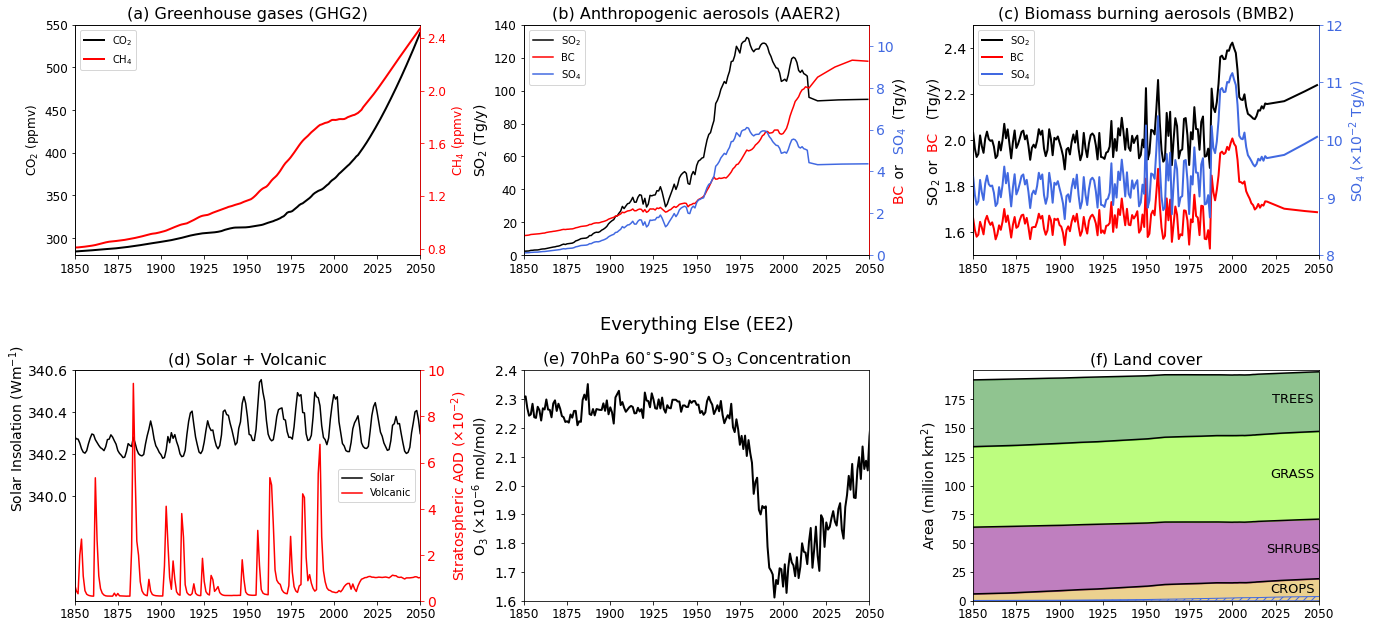

In [21]:
fig = plt.figure(figsize=(16,16))

#-----Greenhouse gases
ax = fig.add_axes([0.0,0.7,0.3,0.2])
ax.set_ylim(280,550)
ax.set_yticks([300,350,400,450,500,550])
ax.set_yticklabels(['300','350','400','450','500','550'], fontsize=12)
line1=ax.plot(ghgs.year, ghgs.co2vmr*1e6, color='black', linewidth=2, label='CO$_{2}$')
ax.set_xlim(1850,2050)
ax.set_xticks([1850,1875,1900,1925,1950,1975,2000,2025,2050])
ax.set_xticklabels(['1850','1875','1900','1925','1950','1975','2000','2025','2050'], fontsize=12)
ax.set_ylabel('CO$_{2}$ (ppmv)', fontsize=12)
ax.set_title('(a) Greenhouse gases (GHG2)', fontsize=16)

ax2 = ax.twinx()
ax2.set_ylim(0.75,2.5)
ax2.set_yticks([0.8,1.2,1.6,2.0,2.4])
ax2.set_yticklabels(['0.8','1.2','1.6','2.0','2.4'], fontsize=12)
ax2.tick_params(axis='y', labelcolor='red', colors='red')
ax2.spines["right"].set_edgecolor('red')
line2=ax2.plot(ghgs.year, ghgs.ch4vmr*1e6, color='red', linewidth=2, label='CH$_{4}$')
ax2.set_ylabel('CH$_{4}$ (ppmv)', fontsize=12)
ax2.yaxis.label.set_color('red')

lines = line1+line2
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc='upper left')
#-----------------------


#----Aerosols
ax = fig.add_axes([0.39,0.7,0.3,0.2])
ax.set_title('(b) Anthropogenic aerosols (AAER2)', fontsize=16)
ax.set_ylim(0,140)
ax.set_xlim(1850,2050)
line1 = ax.plot(aer2_so2.year, aer2_so2, color='black', label='SO$_{2}$')
ax.set_yticks([0,20,40,60,80,100,120,140])
ax.set_yticklabels(['0','20','40','60','80','100','120','140'], fontsize=12)
ax.set_ylabel('SO$_{2}$ (Tg/y)', fontsize=14)
ax.set_xticks([1850,1875,1900,1925,1950,1975,2000,2025,2050])
ax.set_xticklabels(['1850','1875','1900','1925','1950','1975','2000','2025','2050'], fontsize=12)

ax2 = ax.twinx()
ax2.set_ylim(0,11)
ax2.set_yticks([0,2,4,6,8,10])
ax2.set_yticklabels(['0','2','4','6','8','10'], fontsize=14)
line2 = ax2.plot(aer2_bc.year, aer2_bc, color='red', label='BC')
line3 = ax2.plot(aer2_so4.year, aer2_so4, color='royalblue', label='SO$_{4}$')
ax2.tick_params(axis='y', labelcolor='royalblue', colors='royalblue')
ax2.spines["right"].set_edgecolor('red')
ax2.yaxis.label.set_color('red')

lines = line1+line2+line3
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc='upper left')

fig.text(0.71,0.79,'BC                   ', va='center', fontsize=14, rotation='90', color='red')
fig.text(0.71,0.805,'   or          (Tg/y)', va='center', fontsize=14, rotation='90', color='black')
fig.text(0.71,0.8,'      SO$_{4}$       ', va='center', fontsize=14, rotation='90', color='royalblue')
#----

#----Biomass burning aerosols
ax = fig.add_axes([0.78,0.7,0.3,0.2])
ax.set_title('(c) Biomass burning aerosols (BMB2)', fontsize=16)
line1 = ax.plot(bmb2.year, bmb2.bmb_so2, color='black', linewidth=2, label='SO$_{2}$')
line2 = ax.plot(bmb2.year, bmb2.bmb_bc, color='red', linewidth=2, label='BC')
ax.set_ylim(1.5,2.5)
ax.set_xlim(1850,2050)
ax.set_yticks([1.6,1.8,2,2.2,2.4])
ax.set_yticklabels(['1.6','1.8','2.0','2.2','2.4'], fontsize=14)
ax.set_xticks([1850,1875,1900,1925,1950,1975,2000,2025,2050])
ax.set_xticklabels(['1850','1875','1900','1925','1950','1975','2000','2025','2050'], fontsize=12)
fig.text(0.74,0.79,'SO$_{2}$                   ', va='center', fontsize=14, rotation='90', color='black')
fig.text(0.74,0.805,'    or         (Tg/y)', va='center', fontsize=14, rotation='90', color='black')
fig.text(0.74,0.8,'      BC       ', va='center', fontsize=14, rotation='90', color='red')

ax2 = ax.twinx()
line3 = ax2.plot(bmb2.year, bmb2.bmb_so4, color='royalblue', linewidth=2, label='SO$_{4}$')
ax2.set_ylim(0.08,0.12)
ax2.set_yticks([0.08,0.09,0.1,0.11,0.12])
ax2.set_yticklabels(['8','9','10','11','12'], fontsize=14)
ax2.set_ylabel('SO$_{4}$ ($\\times$10$^{-2}$ Tg/y)', fontsize=14)
ax2.tick_params(axis='y', labelcolor='royalblue', colors='royalblue')
ax2.spines["right"].set_edgecolor('royalblue')
ax2.yaxis.label.set_color('royalblue')

lines = line1+line2+line3
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc='upper left')


#----EE (Solin + Volcanoes)
ax = fig.add_axes([0.0,0.4,0.3,0.2])
ax.set_title('(d) Solar + Volcanic', fontsize=16)
ax.set_ylim(339.5,340.6)
ax.set_xlim(1850,2050)
ax.set_yticks([340.0,340.2,340.4,340.6])
ax.set_yticklabels(['340.0','340.2','340.4','340.6'], fontsize=14)
#ax.set_ylabel('Solar Insolation (Wm$^{-1}$)', fontsize=14)
fig.text(-0.05,0.55,'Solar Insolation (Wm$^{-1}$)', fontsize=14, rotation=90, va='center', ha='center')
ax.set_xlim(1850,2050)
ax.set_xticks([1850,1875,1900,1925,1950,1975,2000,2025,2050])
ax.set_xticklabels(['1850','1875','1900','1925','1950','1975','2000','2025','2050'], fontsize=12)

line1 = ax.plot(solin_gm.year, solin_gm, color='black', label='Solar')

ax2 = ax.twinx()
ax2.set_ylim(0,0.1)
line2 = ax2.plot(volcaod.year, volcaod, color='red', label='Volcanic')
ax2.tick_params(axis='y', labelcolor='red', colors='red')
ax2.spines["right"].set_edgecolor('red')
ax2.yaxis.label.set_color('red')
ax2.set_yticks([0,0.02,0.04,0.06,0.08,0.1])
ax2.set_yticklabels(['0','2','4','6','8','10'], fontsize=14)
ax2.set_ylabel('Stratospheric AOD ($\\times$10$^{-2}$)', fontsize=14)

lines = line1+line2
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc='center right')


#--------O3
ax = fig.add_axes([0.39,0.4,0.3,0.2])
ax.set_title('(e) 70hPa 60$^{\circ}$S-90$^{\circ}$S O$_{3}$ Concentration', fontsize=16)
ax.set_xlim(1850,2050)
ax.set_xticks([1850,1875,1900,1925,1950,1975,2000,2025,2050])
ax.set_xticklabels(['1850','1875','1900','1925','1950','1975','2000','2025','2050'], fontsize=12)
ax.set_ylim(1.6e-6,2.4e-6)
ax.set_yticks([1.6e-6,1.7e-6,1.8e-6,1.9e-6,2.0e-6,2.1e-6,2.2e-6,2.3e-6,2.4e-6])
ax.set_yticklabels(['1.6','1.7','1.8','1.9','2.0','2.1','2.2','2.3','2.4'], fontsize=14)
ax.set_ylabel('O$_{3}$ ($\\times$10$^{-6}$ mol/mol)', fontsize=14)

ax.plot(O3shpol.year, O3shpol, color='black', linewidth=2)


ax = fig.add_axes([0.78,0.4,0.3,0.2])
ax.set_ylim(0,200)
ax.set_xlim(1850,2050)
ax.set_xticks([1850,1875,1900,1925,1950,1975,2000,2025,2050])
ax.set_xticklabels(['1850','1875','1900','1925','1950','1975','2000','2025','2050'], fontsize=12)
ax.set_yticks([0,25,50,75,100,125,150,175])
ax.set_yticklabels(['0','25','50','75','100','125','150','175'], fontsize=12)
ax.set_ylabel('Area (million km$^{2}$)', fontsize=14)
ax.set_title('(f) Land cover', fontsize=16) 

ax.fill_between(fraccrop_sum.time, 0, fraccrop_sum, color='goldenrod', alpha=0.5)
ax.plot(fraccrop_sum.time, fraccrop_sum, color='black')
ax.text(2035,10,'CROPS', ha='center', va='center', color='black', fontsize=13)

ax.fill_between(fracshrubs_sum.time,fraccrop_sum, fraccrop_sum + fracshrubs_sum, color='purple', alpha=0.5)
ax.plot(fracshrubs_sum.time, fraccrop_sum + fracshrubs_sum, color='black')
ax.text(2035,45,'SHRUBS', ha='center', va='center', color='black', fontsize=13)

ax.fill_between(fracgrass_sum.time, fraccrop_sum + fracshrubs_sum, fraccrop_sum + fracshrubs_sum + fracgrass_sum, color='lawngreen', alpha=0.5)
ax.plot(fracgrass_sum.time, fraccrop_sum + fracshrubs_sum + fracgrass_sum, color='black')
ax.text(2035,110,'GRASS', ha='center', va='center', color='black', fontsize=13)

ax.fill_between(fracgrass_sum.time, fraccrop_sum + fracshrubs_sum + fracgrass_sum, fraccrop_sum + fracshrubs_sum + fracgrass_sum + fractrees_sum, 
                color='forestgreen', alpha=0.5)
ax.plot(fracgrass_sum.time, fraccrop_sum + fracshrubs_sum + fracgrass_sum + fractrees_sum, color='black')
ax.text(2035,175,'TREES', ha='center', va='center', color='black', fontsize=13)

ax.fill_between(fracirrig_sum.time, 0, fracirrig_sum, facecolor='None', hatch='///', edgecolor='royalblue')

fig.text(0.54,0.64,'Everything Else (EE2)', fontsize=18, ha='center', va='center')

fig.savefig(plotpath+'fig1.png', bbox_inches='tight', facecolor='white')
fig.savefig(plotpath+'fig1.pdf', bbox_inches='tight', facecolor='white')


In [108]:
aer2 = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/FORCINGS/AAER.nc")

Text(0, 0.5, 'SOAG (Tg/y)')

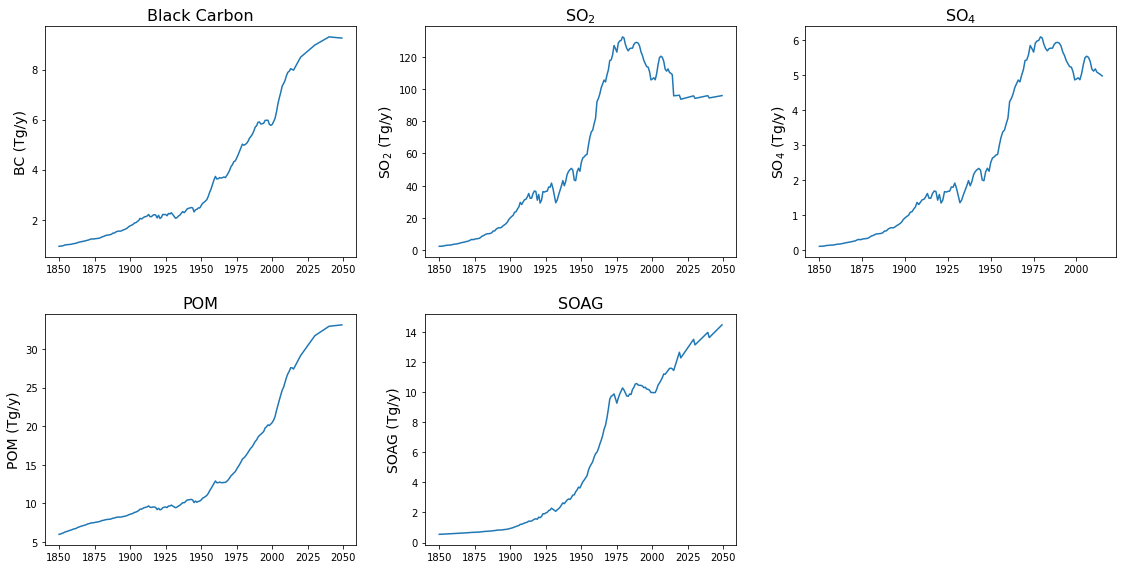

In [109]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_axes([0.02,0.7,0.27,0.2])
ax.plot(aer2.year, aer2.anthro_bc)
ax.set_title('Black Carbon', fontsize=16)
ax.set_ylabel('BC (Tg/y)', fontsize=14)

sum_so2 = aer2.ene_ind_so2 + aer2.ag_so2 + aer2.restran_so2 + aer2.ship_so2
ax = fig.add_axes([0.35,0.7,0.27,0.2])
ax.plot(aer2.year, sum_so2)
ax.set_title('SO$_{2}$', fontsize=16)
ax.set_ylabel('SO$_{2}$ (Tg/y)', fontsize=14)

sum_so4 = aer2.ene_ind_so4 + aer2.ag_so4 + aer2.restran_so4 + aer2.ship_so4
ax = fig.add_axes([0.68,0.7,0.27,0.2])
ax.plot(aer2.year, sum_so4)
ax.set_title('SO$_{4}$', fontsize=16)
ax.set_ylabel('SO$_{4}$ (Tg/y)', fontsize=14)

ax = fig.add_axes([0.02,0.45,0.27,0.2])
ax.plot(aer2.year, aer2.pom)
ax.set_title('POM', fontsize=16)
ax.set_ylabel('POM (Tg/y)', fontsize=14)

ax = fig.add_axes([0.35,0.45,0.27,0.2])
ax.plot(aer2.year, aer2.soag)
ax.set_title('SOAG', fontsize=16)
ax.set_ylabel('SOAG (Tg/y)', fontsize=14)


Text(0, 0.5, 'SOAG (Tg/y)')

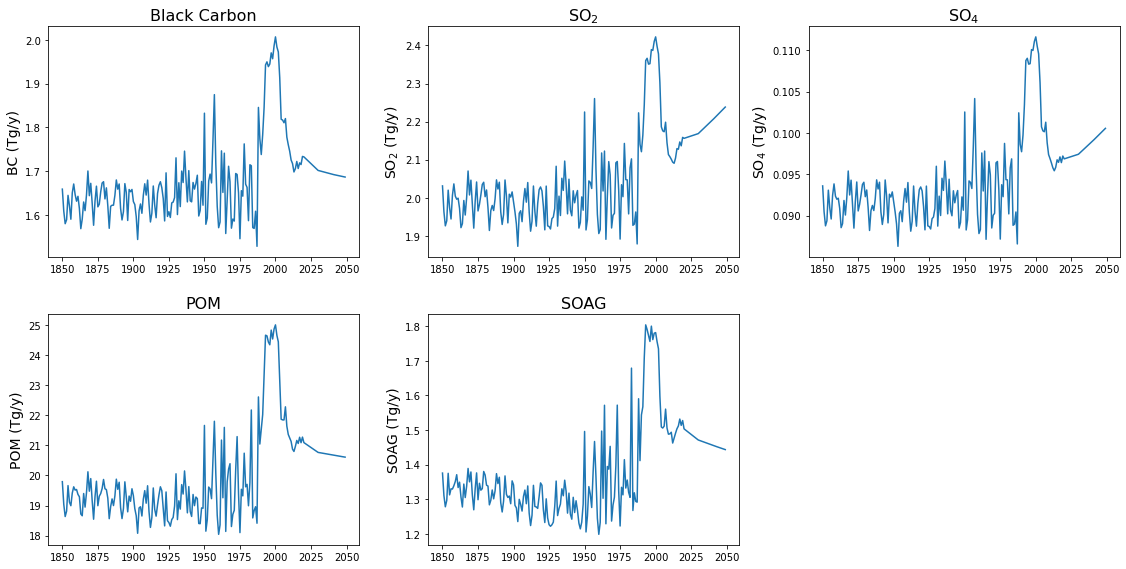

In [53]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_axes([0.02,0.7,0.27,0.2])
ax.plot(bmb2.year, bmb2.bmb_bc)
ax.set_title('Black Carbon', fontsize=16)
ax.set_ylabel('BC (Tg/y)', fontsize=14)

ax = fig.add_axes([0.35,0.7,0.27,0.2])
ax.plot(bmb2.year, bmb2.bmb_so2)
ax.set_title('SO$_{2}$', fontsize=16)
ax.set_ylabel('SO$_{2}$ (Tg/y)', fontsize=14)

ax = fig.add_axes([0.68,0.7,0.27,0.2])
ax.plot(bmb2.year, bmb2.bmb_so4)
ax.set_title('SO$_{4}$', fontsize=16)
ax.set_ylabel('SO$_{4}$ (Tg/y)', fontsize=14)

ax = fig.add_axes([0.02,0.45,0.27,0.2])
ax.plot(bmb2.year, bmb2.bmb_pom)
ax.set_title('POM', fontsize=16)
ax.set_ylabel('POM (Tg/y)', fontsize=14)

ax = fig.add_axes([0.35,0.45,0.27,0.2])
ax.plot(bmb2.year, bmb2.bmb_soag)
ax.set_title('SOAG', fontsize=16)
ax.set_ylabel('SOAG (Tg/y)', fontsize=14)


Text(0, 0.5, 'BC (Tg/y)')

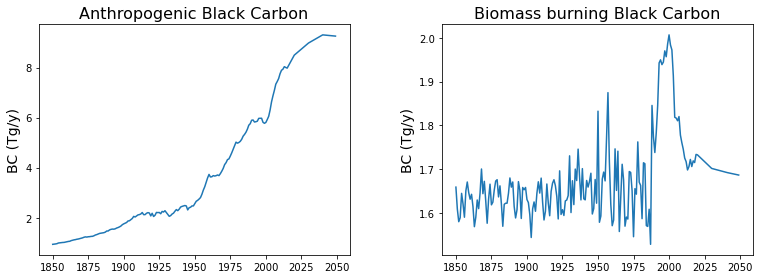

In [56]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_axes([0.02,0.7,0.27,0.2])
ax.plot(aer2.year, aer2.anthro_bc)
ax.set_title('Anthropogenic Black Carbon', fontsize=16)
ax.set_ylabel('BC (Tg/y)', fontsize=14)

ax = fig.add_axes([0.37,0.7,0.27,0.2])
ax.plot(bmb2.year, bmb2.bmb_bc)
ax.set_title('Biomass burning Black Carbon', fontsize=16)
ax.set_ylabel('BC (Tg/y)', fontsize=14)



In [100]:
avog = 6.022e23 # Avogadro's number
re = 6.3712e8 # Radius of the earth in cm

def convert_molecules_to_tg(dat,varname):
    """ Convert surface emissions in molecules/cm2/s to Tg 

    """
    # Start with moleculre/cm2/s.  Convert from molecules to grams.  
    # Divide by Avogadro's number to convert from molecules to moles.  
    #Multiply by molcular weight in g/mol to end up with g/cm2/s
    dat_g = dat[varname].molecular_weight*dat[varname]/avog

    # convert from per s to per year
    dat_g_y = dat_g*365.*86400.

    if "altitude" in dat.dims:
        print('you have altitudes')
        dz = dat.altitude_int[1:dat.altitude_int.size].values - dat.altitude_int[0:dat.altitude_int.size-1].values
        dz = xr.DataArray(dz, coords=[dat.altitude], dims=['altitude'], name='dz')
        dz = dz*1000.*100. # convert to cm
        dat_g_y = (dat_g_y*dz).sum('altitude')


    # Integrate over space
    dlon = np.deg2rad( (dat.lon[2] - dat.lon[1]))
    dlat = np.deg2rad( (dat.lat[2] - dat.lat[1]))
    area = xr.ones_like(dat.isel(time=0))
    weights = np.cos(np.deg2rad(area.lat))*dlat*dlon*re**2. # area in cm2
    dat_g_y_w = dat_g_y.weighted(weights)
    dattot = dat_g_y_w.sum(("lon","lat"))

    # Convert from grams to terra grams
    dattot = dattot/1e12

    return dattot


In [102]:
basepath="/project/cas/islas/python_savs/singleforcing_paper/EMISSIONS/CESM2/AAER/"
soag = xr.open_dataset(basepath+"/SOAG/srf/"+\
"emissions-cmip6-ScenarioMIP_IAMC-AIM-ssp370-1-1_SOAGx1.5_anthro_surface_mol_175001-210101_0.9x1.25_c20200403.nc")
soag_tg = convert_molecules_to_tg(soag,'emiss_anthro')
soag_tg = soag_tg.groupby('time.year').mean('time')
soag_tg = soag_tg.rename('soag')
soag_tg.attrs['units'] = 'Tg/y'

In [105]:
print(soag_tg.year.values)

[1750 1751 1752 1753 1754 1755 1756 1757 1758 1759 1760 1761 1762 1763
 1764 1765 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777
 1778 1779 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791
 1792 1793 1794 1795 1796 1797 1798 1799 1800 1801 1802 1803 1804 1805
 1806 1807 1808 1809 1810 1811 1812 1813 1814 1815 1816 1817 1818 1819
 1820 1821 1822 1823 1824 1825 1826 1827 1828 1829 1830 1831 1832 1833
 1834 1835 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847
 1848 1849 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861
 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875
 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889
 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903
 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917
 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931
 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945
 1946 